In [1]:
import os
os.environ['KMP_DUPLICATE_LIB_OK'] = 'True' 

In [2]:
import hashlib
import os
import tarfile
import zipfile
import requests
import pandas as pd
import torch
from torch import nn

#@save
DATA_HUB = dict()
DATA_URL = 'http://d2l-data.s3-accelerate.amazonaws.com/'

In [3]:
def download(name,cache_dir=os.path.join('..','data')): #@save
    """下载一个DATA_HUB中的文件，默认缓存到`../data`目录下。"""
    assert name in DATA_HUB, f"{name} 不存在于 {DATA_HUB}."
    url, sha1_hash = DATA_HUB[name]
    os.makedirs(cache_dir, exist_ok=True)
    fname = os.path.join(cache_dir, url.split('/')[-1])
    if os.path.exists(fname):
        sha1 = hashlib.sha1()
        with open(fname, 'rb') as f:
            while True:
                data = f.read(1048576)
                if not data:
                    break
                sha1.update(data)
        if sha1.hexdigest() == sha1_hash:
            return fname  # 命中缓存
    print(f'正在从{url}下载{fname}...')
    r = requests.get(url, stream=True, verify=True)
    with open(fname, 'wb') as f:
        f.write(r.content)
    return fname

In [4]:
def download_extract(name,folder=None): #@save
    """下载并解压zip/tar文件"""
    fname = download(name)
    base_dir = os.path.dirname(fname)
    data_dir, ext = os.path.splitext(fname)
    if ext == '.zip':
        fp = zipfile.ZipFile(fname, 'r')
    elif ext in ('.tar', '.gz'):
        fp = tarfile.open(fname, 'r')
    else:
        assert False, 'Only zip/tar files can be extracted.'
    fp.extractall(base_dir)
    return os.path.join(base_dir, folder) if folder else data_dir

def download_all():
    """下载DATA_HUB 所有文件"""
    for name in DATA_HUB:
        download_extract(name)


In [5]:
DATA_HUB['kaggle_house_train'] = ( #@save
    DATA_URL + 'kaggle_house_pred_train.csv',
    '585e9cc93e70b39160e7921475f9bcd7d31219ce')

DATA_HUB['kaggle_house_test'] = ( #@save
    DATA_URL + 'kaggle_house_pred_test.csv',
    'fa19780a7b011d9b009e8bff8e99922a8ee2eb90')

In [6]:
train_file = download('kaggle_house_train')
test_file = download('kaggle_house_test')

In [7]:
train_data = pd.read_csv(train_file)
test_data = pd.read_csv(test_file)

print(train_data.shape, test_data.shape)
print(train_data.head())
print(test_data.head())

(1460, 81) (1459, 80)
   Id  MSSubClass MSZoning  LotFrontage  LotArea Street Alley LotShape  \
0   1          60       RL         65.0     8450   Pave   NaN      Reg   
1   2          20       RL         80.0     9600   Pave   NaN      Reg   
2   3          60       RL         68.0    11250   Pave   NaN      IR1   
3   4          70       RL         60.0     9550   Pave   NaN      IR1   
4   5          60       RL         84.0    14260   Pave   NaN      IR1   

  LandContour Utilities  ... PoolArea PoolQC Fence MiscFeature MiscVal MoSold  \
0         Lvl    AllPub  ...        0    NaN   NaN         NaN       0      2   
1         Lvl    AllPub  ...        0    NaN   NaN         NaN       0      5   
2         Lvl    AllPub  ...        0    NaN   NaN         NaN       0      9   
3         Lvl    AllPub  ...        0    NaN   NaN         NaN       0      2   
4         Lvl    AllPub  ...        0    NaN   NaN         NaN       0     12   

  YrSold  SaleType  SaleCondition  SalePrice  

In [8]:
all_feautres = pd.concat((train_data.iloc[:, 1:-1], test_data.iloc[:, 1:]))
print(all_feautres.shape)

(2919, 79)


In [9]:
# 若无法获得测试数据，可根据训练数据计算均值和标准差
numeric_features = all_feautres.dtypes[all_feautres.dtypes!= "object"].index
all_feautres[numeric_features] = all_feautres[numeric_features].apply(lambda x: (x - x.mean()) / (x.std()))

#在标准化数据之后，所有均值消失，因此我们可以将缺失值设置为0
all_feautres[numeric_features] = all_feautres[numeric_features].fillna(0)
print(all_feautres.shape)

(2919, 79)


In [10]:
# ummy_na = True将na(缺失值) 视为有效的特征值，将为其创建指示特征
all_feautres = pd.get_dummies(all_feautres, dummy_na=True)
print(all_feautres.shape,all_feautres.dtypes)

(2919, 330) MSSubClass               float64
LotFrontage              float64
LotArea                  float64
OverallQual              float64
OverallCond              float64
                          ...   
SaleCondition_Alloca        bool
SaleCondition_Family        bool
SaleCondition_Normal        bool
SaleCondition_Partial       bool
SaleCondition_nan           bool
Length: 330, dtype: object


In [11]:
n_train = train_data.shape[0]
train_featrues = torch.tensor(all_feautres[:n_train].astype('float32').values,dtype=torch.float32)
test_features = torch.tensor(all_feautres[n_train:].astype('float32').values,dtype=torch.float32)
train_labels = torch.tensor(train_data.SalePrice.values.reshape(-1,1),dtype=torch.float32)
print(train_featrues.shape,train_labels.shape,test_features.shape)

torch.Size([1460, 330]) torch.Size([1460, 1]) torch.Size([1459, 330])


In [12]:
#4.10.5 训练
loss = nn.MSELoss()
in_features = train_featrues.shape[1]

def get_net():
    net = nn.Sequential(
        nn.Linear(in_features, 1)
    )
    return net


In [13]:
def log_rmse(net,features,labels):
    """
    计算给定数据集的对数均方根误差
    """
    # 为了取对数时进一步稳定该值，将小于1的值设置为1
    clipped_preds = torch.clamp(net(features), 1, float('inf'))
    rmse = torch.sqrt(loss(torch.log(clipped_preds), torch.log(labels)))
    return rmse.item()


In [14]:
from d2l import torch as d2l
def train(net,train_features,train_labels,test_features,test_labels,num_epochs,learning_rate,weight_decay,batch_size):
    train_ls, test_ls = [], []
    train_iter = d2l.load_array((train_features, train_labels), batch_size)
    optimizer = torch.optim.Adam(net.parameters(), lr=learning_rate, weight_decay=weight_decay)
    for epoch in range(num_epochs):
        for X, y in train_iter:
            optimizer.zero_grad()
            l = loss(net(X), y)
            l.backward()
            optimizer.step()
        train_ls.append(log_rmse(net,train_features, train_labels))
        if test_labels is not None:
            test_ls.append(log_rmse(net,test_features, test_labels))
    return train_ls, test_ls

In [15]:
# 4.10.6 K折交叉验证

def get_k_fold_data(k, i, X, y):
    assert k > 1
    fold_size = X.shape[0] // k
    X_train, y_train = None, None
    for j in range(k):
        idx = slice(j * fold_size,(j+1)*fold_size)
        X_part, y_part = X[idx, :], y[idx]
        if j == i:
            X_valid, y_valid = X_part, y_part
        elif X_train is None:
            X_train, y_train = X_part, y_part
        else:
            X_train = torch.cat((X_train, X_part), dim=0)
            y_train = torch.cat((y_train, y_part), dim=0)
    return X_train, y_train, X_valid, y_valid

In [16]:
def k_fold(k, X_train, y_train, num_epochs, learning_rate, weight_decay, batch_size):
    train_l_sum, valid_l_sum = 0, 0
    for i in range(k):
        data = get_k_fold_data(k, i, X_train, y_train)
        net = get_net()
        train_ls, valid_ls = train(net, *data, num_epochs, learning_rate, weight_decay, batch_size)
        train_l_sum += train_ls[-1]
        valid_l_sum += valid_ls[-1]

        if i == 0:
            d2l.plot(list(range(1, num_epochs + 1)), [train_ls, valid_ls],
                    xlabel='epoch', ylabel='rmse',xlim=[1, num_epochs],  legend=['train', 'valid'],yscale='log')
            
        print(f'折{i+1}, 训练log rmse{float(train_ls[-1]):f}, 验证log rmse{float(valid_ls[-1]):f}')

    return train_l_sum / k, valid_l_sum / k

折1, 训练log rmse0.168967, 验证log rmse0.156636
折2, 训练log rmse0.163896, 验证log rmse0.180605
折3, 训练log rmse0.165038, 验证log rmse0.170058
折4, 训练log rmse0.167556, 验证log rmse0.158559
折5, 训练log rmse0.160977, 验证log rmse0.182907
5-折验证:平均训练log rmse: 0.1653, 平均验证log rmse: 0.1698"耗时：104.422624 秒


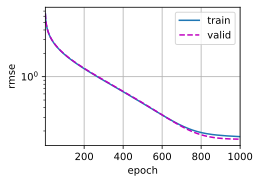

In [17]:
# 4.10.7 模型选择
import time
start = time.time()

k,num_epochs,lr,weight_decay,batch_size = 5,1000,0.5,1e-4,100
train_l,valid_l = k_fold(k,train_featrues,train_labels,num_epochs,lr,weight_decay,batch_size)

end = time.time()

print(f'{k}-折验证:平均训练log rmse: {train_l:.4f}, 平均验证log rmse: {valid_l:.4f}"耗时：{end - start:.6f} 秒')

In [18]:
def train_and_pred(train_featrues,test_features,train_labels,test_data,num_epochs,lr,weight_decay,batch_size):
    # 定义模型
    net = get_net()
    train_ls,_ = train(net,train_featrues,train_labels,None,None,num_epochs,lr,weight_decay,batch_size)
    d2l.plot(list(range(1,num_epochs+1)),[train_ls],xlabel='epoch',ylabel='log rmes',xlim=[1,num_epochs],yscale='log')
    print(f'训练log rmes：{float(train_ls[-1]):.2f}')
    preds = net(test_features).detach().numpy()
    test_data['SalePrice'] = pd.Series(preds.reshape(1,-1)[0])
    submission = pd.concat([test_data['Id'],test_data['SalePrice']],axis=1)
    submission.to_csv('submission.csv',index=False)

训练log rmes：0.16


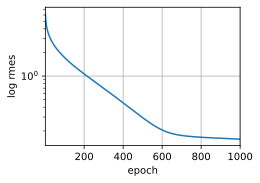

In [19]:
train_and_pred(train_featrues,test_features,train_labels,test_data,num_epochs,lr,weight_decay,batch_size)